In [1]:
#packages importation 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Metar Data Preprocessing

In [2]:
metar_df = pd.read_parquet('metar_katl.parquet')

In [3]:
display(metar_df.head())
print(metar_df.shape)
print(metar_df.dtypes)

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,REM
2,USW00013874,2025-01-01T00:52:00,33.6301,-84.4418,307.8,"ATLANTA HARTSFIELD INTERNATIONAL AIRPORT, GA US",FM-15,343.0,1015.2,0.6,...,56.0,BKN:07 12.19,1015.1,978.1,16.093,5.2,310,11.3,6.7,MET13901/01/25 00:52:02 METAR KATL 010552Z 310...
4,USW00013874,2025-01-01T01:52:00,33.6301,-84.4418,307.8,"ATLANTA HARTSFIELD INTERNATIONAL AIRPORT, GA US",FM-15,343.0,1015.6,0.0,...,56.0,SCT:04 11.58,1015.4,978.4,16.093,4.7,310,13.4,7.7,MET12101/01/25 01:52:02 METAR KATL 010652Z 310...
5,USW00013874,2025-01-01T02:52:00,33.6301,-84.4418,307.8,"ATLANTA HARTSFIELD INTERNATIONAL AIRPORT, GA US",FM-15,343.0,1015.9,0.0,...,61.0,FEW:02 11.58,1015.8,978.8,16.093,4.1,320,NaN,7.2,MET10001/01/25 02:52:02 METAR KATL 010752Z 320...
6,USW00013874,2025-01-01T03:52:00,33.6301,-84.4418,307.8,"ATLANTA HARTSFIELD INTERNATIONAL AIRPORT, GA US",FM-15,343.0,1016.6,0.0,...,63.0,CLR:00,1016.2,979.4,16.093,3.8,320,NaN,5.7,MET10301/01/25 03:52:02 METAR KATL 010852Z 320...
8,USW00013874,2025-01-01T04:52:00,33.6301,-84.4418,307.8,"ATLANTA HARTSFIELD INTERNATIONAL AIRPORT, GA US",FM-15,343.0,1017.3,0.0,...,65.0,CLR:00,1017.2,980.1,16.093,3.5,310,NaN,5.7,MET09701/01/25 04:52:02 METAR KATL 010952Z 310...


(33125, 25)
STATION                       object
DATE                          object
LATITUDE                     float64
LONGITUDE                    float64
ELEVATION                    float64
NAME                          object
REPORT_TYPE                   object
SOURCE                       float64
HourlyAltimeterSetting       float64
HourlyDewPointTemperature    float64
HourlyDryBulbTemperature     float64
HourlyPrecipitation           object
HourlyPresentWeatherType      object
HourlyPressureChange         float64
HourlyPressureTendency       float64
HourlyRelativeHumidity       float64
HourlySkyConditions           object
HourlySeaLevelPressure       float64
HourlyStationPressure        float64
HourlyVisibility              object
HourlyWetBulbTemperature     float64
HourlyWindDirection           object
HourlyWindGustSpeed          float64
HourlyWindSpeed              float64
REM                           object
dtype: object


In [4]:
# Only consider METAR data points
metar_df_o = metar_df.copy()
metar_df = metar_df[metar_df.iloc[:, -1].astype(str).str[24:29] == 'METAR'] #taking last column and looking at char 24-29 for metar (REM col)
# Reduces from 33125 rows to 27716 rows
metar_df.shape

(27716, 25)

In [5]:
# Note: all but 2 data points were taken at the 52nd minute
len(metar_df[metar_df.iloc[:, 1].astype(str).str[14:16] == '52']) #okay so we're ignoring those two
# Convert DATE column to datetime format
metar_df['weather_datetime'] = pd.to_datetime(metar_df['DATE'])
# Replace trace precipitation with 0.01
metar_df['HourlyPrecipitation'] = metar_df['HourlyPrecipitation'].replace('T', '0.01').astype(float)

In [6]:
# See which columns have missing values
nan_columns_idx = np.where(metar_df.isna().sum() != 0)

# Show the columns with missing values
nan_counts = metar_df.isna().sum()
nan_columns = nan_counts.iloc[nan_columns_idx]
nan_columns

HourlyPrecipitation            90
HourlyPresentWeatherType    24847
HourlyPressureChange        18484
HourlyPressureTendency      18484
HourlySkyConditions            10
HourlyStationPressure          36
HourlyVisibility                1
HourlyWetBulbTemperature       36
HourlyWindDirection          1083
HourlyWindGustSpeed         23881
HourlyWindSpeed                 1
dtype: int64

In [7]:
metar_df["HourlyVisibility"] = pd.to_numeric(metar_df["HourlyVisibility"], errors="coerce")
max_v = metar_df.loc[metar_df['HourlySkyConditions']=='CLR:00', 'HourlyVisibility'].max()
print(max_v)

metar_df["HourlyVisibility"] = metar_df["HourlyVisibility"].fillna(max_v)
metar_df["HourlyWindSpeed"] = metar_df["HourlyWindSpeed"].fillna(0)

16.093


In [8]:
p1 = "HourlySeaLevelPressure"
p2 = "HourlyStationPressure"


metar_df[p1] = pd.to_numeric(metar_df[p1], errors="coerce")
metar_df[p2] = pd.to_numeric(metar_df[p2], errors="coerce")

avg_diff = (metar_df[p2] - metar_df[p1]).dropna().mean()

mask = metar_df[p2].isna() & metar_df[p1].notna()
metar_df.loc[mask, p2] = metar_df.loc[mask, p1] + avg_diff

In [9]:
p1 = "HourlyDryBulbTemperature"
p2 = "HourlyWetBulbTemperature"


metar_df[p1] = pd.to_numeric(metar_df[p1], errors="coerce")
metar_df[p2] = pd.to_numeric(metar_df[p2], errors="coerce")

avg_diff = (metar_df[p2] - metar_df[p1]).dropna().mean()

mask = metar_df[p2].isna() & metar_df[p1].notna()
metar_df.loc[mask, p2] = metar_df.loc[mask, p1] + avg_diff

In [10]:
metar_df['HourlyWindGustSpeed'] = metar_df['HourlyWindGustSpeed'].fillna(0)

In [11]:
metar_df['HourlyPrecipitation'] = metar_df['HourlyPrecipitation'].fillna(0)

In [12]:
metar_df['WindDirection_Variable'] = (metar_df['HourlyWindDirection'] == 'VRB').astype(int)
# Convert HourlyWindDirection to numeric; non-numeric values will become NaN
metar_df['HourlyWindDirection'] = pd.to_numeric(metar_df['HourlyWindDirection'], errors="coerce")
# Compute the median excluding NaN values
median_wind_dir = metar_df['HourlyWindDirection'].median()
# Fill missing values with the median
metar_df['HourlyWindDirection'] = metar_df['HourlyWindDirection'].fillna(median_wind_dir)
# Optionally indicate which entries were missing originally (they are now filled with the median)
metar_df["WindDirectionMissing"] = (metar_df['HourlyWindDirection'].isna()).astype(int)

In [13]:
bad_cols = ['HourlyPresentWeatherType', 'HourlyPressureChange', 'HourlyPressureTendency', 'HourlySkyConditions']
metar_df_processed = metar_df.drop(columns=bad_cols)

In [14]:
metar_df_processed.columns

Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
       'REPORT_TYPE', 'SOURCE', 'HourlyAltimeterSetting',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWetBulbTemperature', 'HourlyWindDirection',
       'HourlyWindGustSpeed', 'HourlyWindSpeed', 'REM', 'weather_datetime',
       'WindDirection_Variable', 'WindDirectionMissing'],
      dtype='object')

## OTP Dataset Preprocessing

In [15]:
otp_df = pd.read_parquet('OTP_combined.parquet')
display(otp_df.head())
print(otp_df.shape)
print(otp_df.dtypes)

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,...,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM
0,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N147PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N147PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N153PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N153PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N181GJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1992511, 109)
YEAR                    int64
QUARTER                 int64
MONTH                   int64
DAY_OF_MONTH            int64
DAY_OF_WEEK             int64
                       ...   
DIV5_WHEELS_ON        float64
DIV5_TOTAL_GTIME      float64
DIV5_LONGEST_GTIME    float64
DIV5_WHEELS_OFF       float64
DIV5_TAIL_NUM         float64
Length: 109, dtype: object


In [16]:
# See which columns have missing values
nan_columns_idx = np.where(otp_df.isna().sum() != 0)

# Show the columns with missing values
nan_counts = otp_df.isna().sum()
nan_columns = nan_counts[nan_counts != 0]
nan_column_names = nan_columns.index
nan_columns

TAIL_NUM                 2839
OP_CARRIER_FL_NUM           1
DEP_TIME                22314
DEP_DELAY               22318
DEP_DELAY_NEW           22318
                       ...   
DIV5_WHEELS_ON        1992511
DIV5_TOTAL_GTIME      1992511
DIV5_LONGEST_GTIME    1992511
DIV5_WHEELS_OFF       1992511
DIV5_TAIL_NUM         1992511
Length: 71, dtype: int64

In [17]:
otp_df_o = otp_df.copy()
otp_df = otp_df[['MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_DEL15', 'ARR_TIME_BLK', 
             'CRS_ELAPSED_TIME', 'DISTANCE', 'CANCELLED', 'DIVERTED', 'FL_DATE', 'CRS_DEP_TIME', 'CRS_ARR_TIME']]

In [18]:
# See which columns have missing values
test = otp_df.loc[(otp_df['CANCELLED'] == 0) & (otp_df['DIVERTED'] == 0)] #only canclled and diverted flights involve 15 or more minutes of delay

nan_columns_idx = np.where(test.isna().sum() != 0)

# Show the columns with missing values
nan_counts = test.isna().sum()
nan_columns = nan_counts[nan_counts != 0]
nan_column_names = nan_columns.index
nan_columns

Series([], dtype: int64)

In [19]:
# Convert FL_DATE column to datetime format
otp_df['FL_DATE'] = pd.to_datetime(otp_df['FL_DATE'], format = 'mixed') #added format mixed

# Create a new column that takes the CRS_DEP_TIME column if its origin is ATL, and if not, takes the CRS_ARR_TIME column
otp_df['time_val'] = np.where(otp_df['ORIGIN'] == 'ATL', otp_df['CRS_DEP_TIME'], otp_df['CRS_ARR_TIME'])

# Deal with times that are 3 digits long by padding with a 0 in front
otp_df['time_val'] = otp_df['time_val'].astype(str).str.zfill(4)

# Extract hour and minute from time_val column
otp_df['hour'] = otp_df['time_val'].str.slice(0, 2).astype(int)
otp_df['minute'] = otp_df['time_val'].str.slice(2, 4).astype(int)

# Create flight datetime column
otp_df['flight_datetime'] = (otp_df['FL_DATE'].dt.normalize() +
                             pd.to_timedelta(otp_df['hour'], unit='h') +
                             pd.to_timedelta(otp_df['minute'], unit='m'))

In [20]:
# Sort the dataframes (required for merge_asof)
otp_df_sorted = otp_df.sort_values('flight_datetime')
metar_df_sorted = metar_df_processed.sort_values('weather_datetime')

## Combined Dataset

In [21]:
# Perform an as-of merge using the flight datetime (from otp_df) and the weather datetime (from metar_df)
merged_df = pd.merge_asof(
    otp_df_sorted,
    metar_df_sorted,
    left_on='flight_datetime',
    right_on='weather_datetime',
    direction='nearest'  # Matches the closest record, whether before or after.
)

In [22]:
display(merged_df.head())
print(merged_df.shape)
print(merged_df.dtypes)

,MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,...,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,REM,weather_datetime,WindDirection_Variable,WindDirectionMissing
0,1,6,UA,EWR,ATL,1.0,2100-2159,1.0,0001-0559,153.0,...,977.1,16.093,18.9,200.0,0.0,4.1,MET13201/01/22 00:52:02 METAR KATL 010552Z 200...,2022-01-01 00:52:00,0,0
1,1,6,NK,MSP,ATL,1.0,2000-2059,1.0,0001-0559,167.0,...,977.1,16.093,18.9,200.0,0.0,4.1,MET13201/01/22 00:52:02 METAR KATL 010552Z 200...,2022-01-01 00:52:00,0,0
2,1,6,WN,STL,ATL,0.0,2100-2159,0.0,0001-0559,90.0,...,977.1,16.093,18.9,200.0,0.0,4.1,MET13201/01/22 00:52:02 METAR KATL 010552Z 200...,2022-01-01 00:52:00,0,0
3,1,6,DL,LAX,ATL,1.0,1700-1759,1.0,0001-0559,246.0,...,977.1,16.093,18.9,200.0,0.0,4.1,MET13201/01/22 00:52:02 METAR KATL 010552Z 200...,2022-01-01 00:52:00,0,0
4,1,6,AA,MIA,ATL,0.0,2200-2259,0.0,0001-0559,118.0,...,977.1,16.093,18.9,200.0,0.0,4.1,MET13201/01/22 00:52:02 METAR KATL 010552Z 200...,2022-01-01 00:52:00,0,0


(1992511, 44)
MONTH                                 int64
DAY_OF_WEEK                           int64
OP_CARRIER                           object
ORIGIN                               object
DEST                                 object
DEP_DEL15                           float64
DEP_TIME_BLK                         object
ARR_DEL15                           float64
ARR_TIME_BLK                         object
CRS_ELAPSED_TIME                    float64
DISTANCE                            float64
CANCELLED                           float64
DIVERTED                            float64
FL_DATE                      datetime64[ns]
CRS_DEP_TIME                          int64
CRS_ARR_TIME                          int64
time_val                             object
hour                                  int32
minute                                int32
flight_datetime              datetime64[ns]
STATION                              object
DATE                                 object
LATITUDE          

In [23]:
flight_delay_dataset = merged_df.copy()
flight_delay_dataset['flight_id'] = flight_delay_dataset.index
test = flight_delay_dataset.loc[(flight_delay_dataset['CANCELLED'] == 0) & (flight_delay_dataset['DIVERTED'] == 0)]
nan_counts = test.isna().sum()
nan_columns = nan_counts[nan_counts != 0]
nan_column_names = nan_columns.index

# If we were to remove all rows with any missing values in the columns shown above, what percent of the data would it be?
rows_with_nan_mask = test[nan_column_names].isna().any(axis=1)

percent_removed = rows_with_nan_mask.sum()/len(test)
percent_removed #none provided we exclude cancelled and diverted flights from modeling task (can be part of prediction task)

0.0

In [24]:
try:
    #determined effects of diversion and cancelled flights on routes
    flight_delay_dataset['index'] = flight_delay_dataset.index
    test['index'] = test.index
    test2 = flight_delay_dataset.groupby(by = ['ORIGIN', 'DEST'])['index'].count().reset_index().rename(columns = {'index' : 'num_flights'})
    test3 = test.groupby(by = ['ORIGIN', 'DEST'])['index'].count().reset_index().rename(columns = {'index' : 'num_filtered_flights'})

    test4 = test2.merge(test3, on = ['ORIGIN','DEST'], how = 'inner')
    test4['diff'] = test4['num_flights'] - test4['num_filtered_flights']
    test4['route'] = test4['ORIGIN'] + ', ' + test4['DEST']

    test5 = test4[['route', 'diff']].copy()

    problematic_flights = test4.copy()
    problematic_flights_simplified = test5.copy()

    del test,test2,test3,test4,test5
except:
    print('still good; test cases still gone')

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_25520\804180084.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['index'] = test.index


In [25]:
#Identification of most affected routes by exclusion of cancellations and diversions from flight delay logic. 
display(problematic_flights.head())
print("Top 25 problematic routes")
display(problematic_flights_simplified.sort_values(by = 'diff', ascending= False).head(25))
print("Least 25 problematic routes")
display(problematic_flights_simplified.sort_values(by = 'diff', ascending= True).head(25))

,ORIGIN,DEST,num_flights,num_filtered_flights,diff,route
0,ABE,ATL,2910,2876,34,"ABE, ATL"
1,ABQ,ATL,3028,2996,32,"ABQ, ATL"
2,ABY,ATL,2542,2526,16,"ABY, ATL"
3,ACY,ATL,109,109,0,"ACY, ATL"
4,AEX,ATL,2455,2431,24,"AEX, ATL"


Top 25 problematic routes


,route,diff
94,"ATL, LGA",693
246,"LGA, ATL",619
59,"ATL, EWR",573
211,"EWR, ATL",506
97,"ATL, MCO",434
51,"ATL, DFW",416
249,"MCO, ATL",408
49,"ATL, DCA",382
201,"DCA, ATL",375
203,"DFW, ATL",365


Least 25 problematic routes


,route,diff
309,"SWF, ATL",0
3,"ACY, ATL",0
267,"OGG, ATL",0
294,"SCE, ATL",0
142,"ATL, SCE",0
165,"ATL, TVC",1
287,"RST, ATL",1
115,"ATL, OGG",1
157,"ATL, SWF",1
135,"ATL, RST",1


In [26]:
flight_delay_dataset.columns

Index(['MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_DEL15',
       'DEP_TIME_BLK', 'ARR_DEL15', 'ARR_TIME_BLK', 'CRS_ELAPSED_TIME',
       'DISTANCE', 'CANCELLED', 'DIVERTED', 'FL_DATE', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'time_val', 'hour', 'minute', 'flight_datetime',
       'STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
       'REPORT_TYPE', 'SOURCE', 'HourlyAltimeterSetting',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWetBulbTemperature', 'HourlyWindDirection',
       'HourlyWindGustSpeed', 'HourlyWindSpeed', 'REM', 'weather_datetime',
       'WindDirection_Variable', 'WindDirectionMissing', 'flight_id', 'index'],
      dtype='object')

In [27]:
good_cols = ['MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_DEL15',
       'DEP_TIME_BLK', 'ARR_DEL15', 'ARR_TIME_BLK', 'CRS_ELAPSED_TIME',
       'DISTANCE', 'CANCELLED', 'DIVERTED', 'FL_DATE', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'HourlyAltimeterSetting',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWetBulbTemperature', 'HourlyWindDirection',
       'HourlyWindGustSpeed', 'HourlyWindSpeed',
       'WindDirection_Variable', 'WindDirectionMissing', 'flight_id']
flight_delay_dataset = flight_delay_dataset[good_cols]

## Model Dataset Preprocessing

In [28]:
#model dataset 
fd_model_data = flight_delay_dataset.copy()
fd_model_data = fd_model_data.loc[(fd_model_data['CANCELLED'] == 0) & (fd_model_data['DIVERTED'] == 0)]
unnecessary_cols = ['FL_DATE', 'CANCELLED', 'DIVERTED']
fd_model_data = fd_model_data.drop(columns=unnecessary_cols)
fd_model_data.dtypes

MONTH                          int64
DAY_OF_WEEK                    int64
OP_CARRIER                    object
ORIGIN                        object
DEST                          object
DEP_DEL15                    float64
DEP_TIME_BLK                  object
ARR_DEL15                    float64
ARR_TIME_BLK                  object
CRS_ELAPSED_TIME             float64
DISTANCE                     float64
CRS_DEP_TIME                   int64
CRS_ARR_TIME                   int64
HourlyAltimeterSetting       float64
HourlyDewPointTemperature    float64
HourlyDryBulbTemperature     float64
HourlyPrecipitation          float64
HourlyRelativeHumidity       float64
HourlySeaLevelPressure       float64
HourlyStationPressure        float64
HourlyVisibility             float64
HourlyWetBulbTemperature     float64
HourlyWindDirection          float64
HourlyWindGustSpeed          float64
HourlyWindSpeed              float64
WindDirection_Variable         int32
WindDirectionMissing           int32
f

In [29]:
# Extract hour values from the scheduled hour to use in model
fd_model_data['DEP_HOUR'] = fd_model_data['DEP_TIME_BLK'].str.slice(0, 2).astype(int)
fd_model_data = fd_model_data.drop(columns=['DEP_TIME_BLK'])

fd_model_data['ARR_HOUR'] = fd_model_data['ARR_TIME_BLK'].str.slice(0, 2).astype(int)
fd_model_data = fd_model_data.drop(columns=['ARR_TIME_BLK'])

# Perform cyclical encoding for MONTH, DEP_HOUR, and ARR_HOUR columns 
fd_model_data['month_sin'] = np.sin(2 * np.pi * fd_model_data['MONTH'] / 12)
fd_model_data['month_cos'] = np.cos(2 * np.pi * fd_model_data['MONTH'] / 12)
fd_model_data = fd_model_data.drop(columns=['MONTH'])

fd_model_data['dep_hour_sin'] = np.sin(2 * np.pi * fd_model_data['DEP_HOUR'] / 24)
fd_model_data['dep_hour_cos'] = np.cos(2 * np.pi * fd_model_data['DEP_HOUR'] / 24)
fd_model_data = fd_model_data.drop(columns=['DEP_HOUR'])

fd_model_data['arr_hour_sin'] = np.sin(2 * np.pi * fd_model_data['ARR_HOUR'] / 24)
fd_model_data['arr_hour_cos'] = np.cos(2 * np.pi * fd_model_data['ARR_HOUR'] / 24)
fd_model_data = fd_model_data.drop(columns=['ARR_HOUR'])

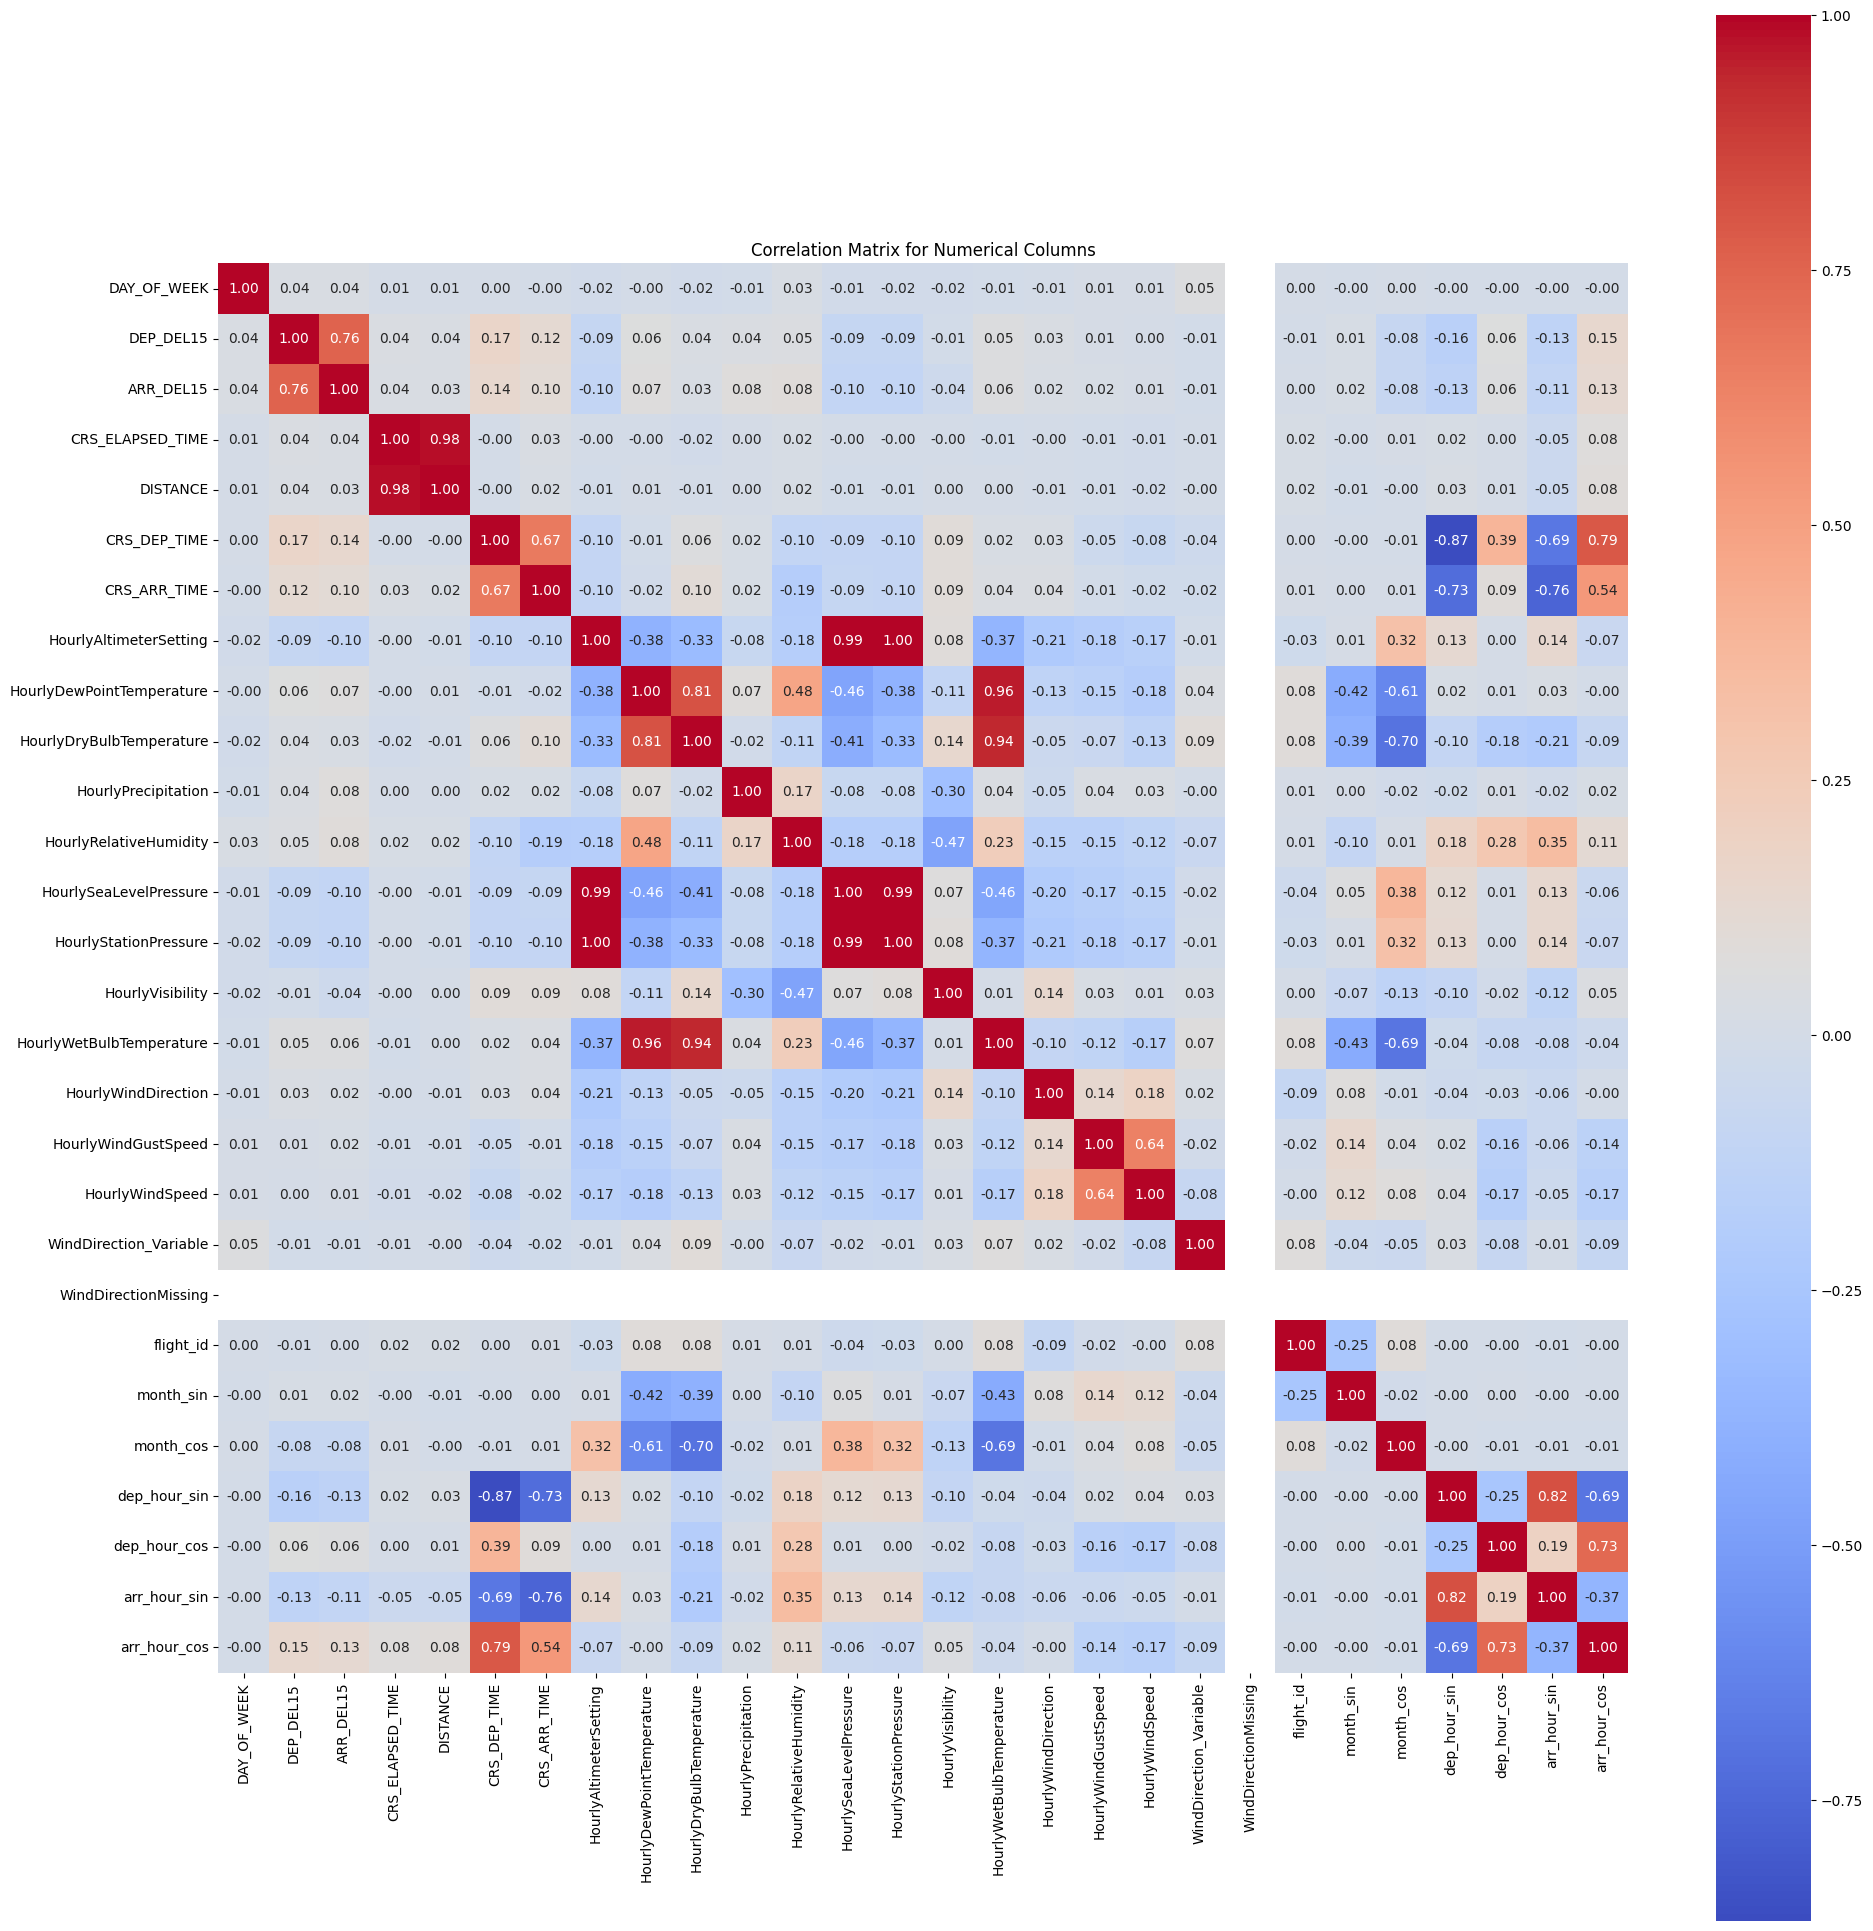

In [30]:
# Show correlation matrix for numerical columns
numeric = fd_model_data.select_dtypes(include=[np.number]).dropna()
corr_matrix = numeric.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix for Numerical Columns")
plt.tight_layout()
plt.show()

In [31]:
#Huge Correlation with Tempatures - Dropping Dry and Wet... keeping Dew Point
temp_cols = ['HourlyDewPointTemperature','HourlyWetBulbTemperature']
fd_model_data = fd_model_data.drop(columns=temp_cols)

In [32]:
# Split data into ATL departures and arrivals

#for model training - decided two models
atl_deps_model = fd_model_data[fd_model_data['ORIGIN']=='ATL']
atl_arrs_model = fd_model_data[fd_model_data['DEST']=='ATL']

#for model prediction - inclusive of cancellations & diversions 
atl_deps_complete = flight_delay_dataset[flight_delay_dataset['ORIGIN']=='ATL']
atl_arrs_complete = flight_delay_dataset[flight_delay_dataset['DEST']=='ATL']

In [33]:
display(atl_deps_model.head())
print(atl_deps_model.shape)
print(atl_deps_model.columns)
display(atl_arrs_model.head())
print(atl_arrs_model.shape)
print(atl_deps_model.columns)

,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_DEL15,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME,CRS_ARR_TIME,...,HourlyWindSpeed,WindDirection_Variable,WindDirectionMissing,flight_id,month_sin,month_cos,dep_hour_sin,dep_hour_cos,arr_hour_sin,arr_hour_cos
9,6,AA,ATL,MIA,0.0,0.0,120.0,594.0,515,715,...,4.6,0,0,9,0.5,0.866025,0.0,1.000000e+00,0.965926,-0.258819
10,6,NK,ATL,FLL,1.0,0.0,117.0,581.0,520,717,...,4.6,0,0,10,0.5,0.866025,0.0,1.000000e+00,0.965926,-0.258819
13,6,NK,ATL,MCO,0.0,0.0,100.0,404.0,530,710,...,3.6,0,0,13,0.5,0.866025,0.0,1.000000e+00,0.965926,-0.258819
14,6,B6,ATL,FLL,0.0,0.0,111.0,581.0,549,740,...,3.6,0,0,14,0.5,0.866025,0.0,1.000000e+00,0.965926,-0.258819
15,6,NK,ATL,LAX,1.0,1.0,287.0,1947.0,600,747,...,3.6,0,0,15,0.5,0.866025,1.0,6.123234e-17,0.965926,-0.258819


(982873, 29)
Index(['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_DEL15', 'ARR_DEL15',
       'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
       'HourlyAltimeterSetting', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
       'WindDirection_Variable', 'WindDirectionMissing', 'flight_id',
       'month_sin', 'month_cos', 'dep_hour_sin', 'dep_hour_cos',
       'arr_hour_sin', 'arr_hour_cos'],
      dtype='object')


,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_DEL15,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME,CRS_ARR_TIME,...,HourlyWindSpeed,WindDirection_Variable,WindDirectionMissing,flight_id,month_sin,month_cos,dep_hour_sin,dep_hour_cos,arr_hour_sin,arr_hour_cos
0,6,UA,EWR,ATL,1.0,1.0,153.0,746.0,2129,2,...,4.1,0,0,0,0.5,0.866025,-0.707107,0.707107,0.0,1.0
1,6,NK,MSP,ATL,1.0,1.0,167.0,907.0,2025,12,...,4.1,0,0,1,0.5,0.866025,-0.866025,0.500000,0.0,1.0
2,6,WN,STL,ATL,0.0,0.0,90.0,484.0,2145,15,...,4.1,0,0,2,0.5,0.866025,-0.707107,0.707107,0.0,1.0
3,6,DL,LAX,ATL,1.0,1.0,246.0,1947.0,1713,19,...,4.1,0,0,3,0.5,0.866025,-0.965926,-0.258819,0.0,1.0
4,6,AA,MIA,ATL,0.0,0.0,118.0,594.0,2222,20,...,4.1,0,0,4,0.5,0.866025,-0.500000,0.866025,0.0,1.0


(982876, 29)
Index(['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_DEL15', 'ARR_DEL15',
       'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
       'HourlyAltimeterSetting', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
       'WindDirection_Variable', 'WindDirectionMissing', 'flight_id',
       'month_sin', 'month_cos', 'dep_hour_sin', 'dep_hour_cos',
       'arr_hour_sin', 'arr_hour_cos'],
      dtype='object')


In [34]:
print(atl_deps_model.dtypes)

DAY_OF_WEEK                   int64
OP_CARRIER                   object
ORIGIN                       object
DEST                         object
DEP_DEL15                   float64
ARR_DEL15                   float64
CRS_ELAPSED_TIME            float64
DISTANCE                    float64
CRS_DEP_TIME                  int64
CRS_ARR_TIME                  int64
HourlyAltimeterSetting      float64
HourlyDryBulbTemperature    float64
HourlyPrecipitation         float64
HourlyRelativeHumidity      float64
HourlySeaLevelPressure      float64
HourlyStationPressure       float64
HourlyVisibility            float64
HourlyWindDirection         float64
HourlyWindGustSpeed         float64
HourlyWindSpeed             float64
WindDirection_Variable        int32
WindDirectionMissing          int32
flight_id                     int64
month_sin                   float64
month_cos                   float64
dep_hour_sin                float64
dep_hour_cos                float64
arr_hour_sin                

In [35]:
print(atl_arrs_model.dtypes)

DAY_OF_WEEK                   int64
OP_CARRIER                   object
ORIGIN                       object
DEST                         object
DEP_DEL15                   float64
ARR_DEL15                   float64
CRS_ELAPSED_TIME            float64
DISTANCE                    float64
CRS_DEP_TIME                  int64
CRS_ARR_TIME                  int64
HourlyAltimeterSetting      float64
HourlyDryBulbTemperature    float64
HourlyPrecipitation         float64
HourlyRelativeHumidity      float64
HourlySeaLevelPressure      float64
HourlyStationPressure       float64
HourlyVisibility            float64
HourlyWindDirection         float64
HourlyWindGustSpeed         float64
HourlyWindSpeed             float64
WindDirection_Variable        int32
WindDirectionMissing          int32
flight_id                     int64
month_sin                   float64
month_cos                   float64
dep_hour_sin                float64
dep_hour_cos                float64
arr_hour_sin                

In [36]:
extra_cols = ['FL_DATE', 'CANCELLED', 'DIVERTED', 'HourlyDewPointTemperature','HourlyWetBulbTemperature']

#preprocessing on complete set
atl_deps_complete = atl_deps_complete.drop(columns=extra_cols)

# Extract hour values from the scheduled hour to use in model
atl_deps_complete['DEP_HOUR'] = atl_deps_complete['DEP_TIME_BLK'].str.slice(0, 2).astype(int)
atl_deps_complete = atl_deps_complete.drop(columns=['DEP_TIME_BLK'])

atl_deps_complete['ARR_HOUR'] = atl_deps_complete['ARR_TIME_BLK'].str.slice(0, 2).astype(int)
atl_deps_complete = atl_deps_complete.drop(columns=['ARR_TIME_BLK'])

# Perform cyclical encoding for MONTH, DEP_HOUR, and ARR_HOUR columns 
atl_deps_complete['month_sin'] = np.sin(2 * np.pi * atl_deps_complete['MONTH'] / 12)
atl_deps_complete['month_cos'] = np.cos(2 * np.pi * atl_deps_complete['MONTH'] / 12)
atl_deps_complete = atl_deps_complete.drop(columns=['MONTH'])

atl_deps_complete['dep_hour_sin'] = np.sin(2 * np.pi * atl_deps_complete['DEP_HOUR'] / 24)
atl_deps_complete['dep_hour_cos'] = np.cos(2 * np.pi * atl_deps_complete['DEP_HOUR'] / 24)
atl_deps_complete = atl_deps_complete.drop(columns=['DEP_HOUR'])

atl_deps_complete['arr_hour_sin'] = np.sin(2 * np.pi * atl_deps_complete['ARR_HOUR'] / 24)
atl_deps_complete['arr_hour_cos'] = np.cos(2 * np.pi * atl_deps_complete['ARR_HOUR'] / 24)
atl_deps_complete = atl_deps_complete.drop(columns=['ARR_HOUR'])

#arrivals turn
atl_arrs_complete = atl_arrs_complete.drop(columns=extra_cols)

# Extract hour values from the scheduled hour to use in model
atl_arrs_complete['DEP_HOUR'] = atl_arrs_complete['DEP_TIME_BLK'].str.slice(0, 2).astype(int)
atl_arrs_complete = atl_arrs_complete.drop(columns=['DEP_TIME_BLK'])

atl_arrs_complete['ARR_HOUR'] = atl_arrs_complete['ARR_TIME_BLK'].str.slice(0, 2).astype(int)
atl_arrs_complete = atl_arrs_complete.drop(columns=['ARR_TIME_BLK'])

# Perform cyclical encoding for MONTH, DEP_HOUR, and ARR_HOUR columns 
atl_arrs_complete['month_sin'] = np.sin(2 * np.pi * atl_arrs_complete['MONTH'] / 12)
atl_arrs_complete['month_cos'] = np.cos(2 * np.pi * atl_arrs_complete['MONTH'] / 12)
atl_arrs_complete = atl_arrs_complete.drop(columns=['MONTH'])

atl_arrs_complete['dep_hour_sin'] = np.sin(2 * np.pi * atl_arrs_complete['DEP_HOUR'] / 24)
atl_arrs_complete['dep_hour_cos'] = np.cos(2 * np.pi * atl_arrs_complete['DEP_HOUR'] / 24)
atl_arrs_complete = atl_arrs_complete.drop(columns=['DEP_HOUR'])

atl_arrs_complete['arr_hour_sin'] = np.sin(2 * np.pi * atl_arrs_complete['ARR_HOUR'] / 24)
atl_arrs_complete['arr_hour_cos'] = np.cos(2 * np.pi * atl_arrs_complete['ARR_HOUR'] / 24)
atl_arrs_complete = atl_arrs_complete.drop(columns=['ARR_HOUR'])

In [37]:
drop_dest_orig = ['ORIGIN', 'DEST']
atl_deps_model = atl_deps_model.drop(columns=drop_dest_orig)
atl_deps_complete = atl_deps_complete.drop(columns=drop_dest_orig)
atl_arrs_model = atl_arrs_model.drop(columns=drop_dest_orig)
atl_arrs_complete = atl_arrs_complete.drop(columns=drop_dest_orig)

In [38]:
dep_cat_cols = ['DAY_OF_WEEK', 'OP_CARRIER']
arr_cat_cols = ['DAY_OF_WEEK', 'OP_CARRIER']

atl_deps_model_e = pd.get_dummies(atl_deps_model, columns=dep_cat_cols, drop_first=True)
atl_arrs_model_e = pd.get_dummies(atl_arrs_model, columns=arr_cat_cols, drop_first=True)

atl_deps_complete_e = pd.get_dummies(atl_deps_complete, columns=dep_cat_cols, drop_first=True)
atl_arrs_complete_e = pd.get_dummies(atl_arrs_complete, columns=arr_cat_cols, drop_first=True)

## Model Training

In [39]:
# Separate the predictor variables from the response variable
atl_deps_X = atl_deps_model_e.drop(columns=['DEP_DEL15','ARR_DEL15','flight_id'], axis=1)
atl_deps_y = atl_deps_model_e['DEP_DEL15']
atl_deps_id = atl_deps_model_e['flight_id']

atl_arrs_X = atl_arrs_model_e.drop(columns=['DEP_DEL15','ARR_DEL15','flight_id'], axis=1)
atl_arrs_y = atl_arrs_model_e['ARR_DEL15']
atl_arrs_id = atl_arrs_model_e['flight_id']

from sklearn.model_selection import train_test_split
# Split the data into train and test data, using a 80/20 split -> doing cross/val

atl_deps_X_train, atl_deps_X_test, atl_deps_y_train, atl_deps_y_test, atl_deps_id_train, atl_deps_id_test  = train_test_split(atl_deps_X, atl_deps_y, atl_deps_id, test_size=0.2, stratify=atl_deps_y, random_state=6242)

atl_arrs_X_train, atl_arrs_X_test, atl_arrs_y_train, atl_arrs_y_test, atl_arrs_id_train, atl_arrs_id_test = train_test_split(atl_arrs_X, atl_arrs_y, atl_arrs_id, test_size=0.2, stratify=atl_arrs_y, random_state=6242)

In [40]:
atl_deps_X_train.columns

Index(['CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
       'HourlyAltimeterSetting', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
       'WindDirection_Variable', 'WindDirectionMissing', 'month_sin',
       'month_cos', 'dep_hour_sin', 'dep_hour_cos', 'arr_hour_sin',
       'arr_hour_cos', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
       'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7', 'OP_CARRIER_AA',
       'OP_CARRIER_AS', 'OP_CARRIER_B6', 'OP_CARRIER_DL', 'OP_CARRIER_F9',
       'OP_CARRIER_MQ', 'OP_CARRIER_NK', 'OP_CARRIER_OH', 'OP_CARRIER_OO',
       'OP_CARRIER_UA', 'OP_CARRIER_WN', 'OP_CARRIER_YV', 'OP_CARRIER_YX'],
      dtype='object')

## Random Search CV

In [41]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
RandomizedSearchCV
from sklearn.metrics import (confusion_matrix, recall_score, classification_report, precision_score,
                              accuracy_score, roc_auc_score, average_precision_score, make_scorer, roc_curve)

# Define a custom KS score function
def ks_score(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return max(tpr - fpr)
# Add KS score as a scorer
ks_scorer = make_scorer(ks_score, needs_proba=True)

values = [0.3, 0.4, 0.5, 0.7, 0.8, 0.9]

# Define the parameter grid to search
param_distributions = {
    "smote__sampling_strategy":[0.5,'auto'],
    "smote__k_neighbors": [3, 5, 7],
    "rf__n_estimators": [25,50,100,150,200],
    "rf__max_depth": [5,10,20,30,50,60,80],
    "rf__min_samples_split": randint(2, 11),
    "rf__min_samples_leaf": randint(3, 10),
    "rf__max_features": [0.8,1.0],
    "rf__bootstrap": [True, False],
    "rf__criterion": ["gini", "entropy"]
}

c:\Users\Yusuf\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [42]:
atl_deps_X_sample, _, atl_deps_y_sample, _ = train_test_split(
    atl_deps_X_train,
    atl_deps_y_train,
    train_size=0.30,
    stratify=atl_deps_y_train,   
    random_state=6242
)

print("Sample size:", atl_deps_X_sample.shape[0])

Sample size: 235889


In [43]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Initialize the base models
rf_dep_base = Pipeline([
    ("smote", SMOTE(random_state=6242)),
    ("rf", RandomForestClassifier(class_weight="balanced_subsample", random_state=6242))
])

scoring = {
    "roc_auc":   "roc_auc",
    "precision": "precision",
    "recall":    "recall",
    "f1":        "f1"
}


# Setup randomized searches with 20 iterations and 3-fold cross-validation
random_search_dep = RandomizedSearchCV(
    estimator=rf_dep_base,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring=scoring,
    refit= 'f1',
    random_state=6242,
    n_jobs=-1,
    verbose = 4
)

# Fit on the training data
random_search_dep.fit(atl_deps_X_sample, atl_deps_y_sample)
print(random_search_dep.best_params_)

# Get the best estimator
rf_dep_model = random_search_dep.best_estimator_
print(rf_dep_model)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'rf__bootstrap': False, 'rf__criterion': 'entropy', 'rf__max_depth': 60, 'rf__max_features': 0.8, 'rf__min_samples_leaf': 9, 'rf__min_samples_split': 2, 'rf__n_estimators': 200, 'smote__k_neighbors': 7, 'smote__sampling_strategy': 0.5}
Pipeline(steps=[('smote',
                 SMOTE(k_neighbors=7, random_state=6242,
                       sampling_strategy=0.5)),
                ('rf',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=60,
                                        max_features=0.8, min_samples_leaf=9,
                                        n_estimators=200, random_state=6242))])


In [44]:
rf_dep_model.fit(atl_deps_X_train,atl_deps_y_train)

Pipeline(steps=[('smote',
                 SMOTE(k_neighbors=7, random_state=6242,
                       sampling_strategy=0.5)),
                ('rf',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=60,
                                        max_features=0.8, min_samples_leaf=9,
                                        n_estimators=200, random_state=6242))])

In [45]:
#save model to files
import joblib
from joblib import dump, load
joblib.dump(rf_dep_model,'rf_dep_model.joblib')

['rf_dep_model.joblib']

In [46]:
#load local model or one saved 

import os
path = "rf_dep_model.joblib"


try:
    rf_dep_model
    print('model exists')
except NameError:
    
    if os.path.exists(path):
        rf_dep_model = load(path)
        print(f"Loaded model from {path}")
    else:
        raise FileNotFoundError(f"No model file found at {path}")

model exists


Departure Delay Prediction Metrics:
Accuracy: 0.7911
Precision: 0.4711
Recall: 0.3740
ROC AUC: 0.7139
PR AUC: 0.4500

Detailed Classification Report for Departures:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87    157316
         1.0       0.47      0.37      0.42     39259

    accuracy                           0.79    196575
   macro avg       0.66      0.63      0.64    196575
weighted avg       0.78      0.79      0.78    196575

KS Score for Departure Delay Predictions: 0.3162


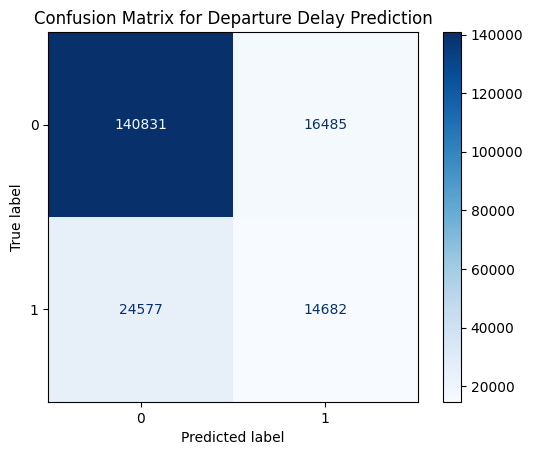

In [47]:
# Predict probabilities and classes on the test sets
dep_y_pred_proba = rf_dep_model.predict_proba(atl_deps_X_test)
dep_delay_probabilities = dep_y_pred_proba[:, 1]
dep_y_pred = rf_dep_model.predict(atl_deps_X_test)

# Evaluate the model
# Departures
dep_accuracy = accuracy_score(atl_deps_y_test, dep_y_pred)
dep_precision = precision_score(atl_deps_y_test, dep_y_pred)
dep_recall = recall_score(atl_deps_y_test, dep_y_pred)
dep_roc_auc = roc_auc_score(atl_deps_y_test, dep_delay_probabilities)
dep_pr_auc = average_precision_score(atl_deps_y_test, dep_delay_probabilities)

# Create confusion matrix
dep_cm = confusion_matrix(atl_deps_y_test, dep_y_pred)

# Print results
print("Departure Delay Prediction Metrics:")
print(f"Accuracy: {dep_accuracy:.4f}")
print(f"Precision: {dep_precision:.4f}")
print(f"Recall: {dep_recall:.4f}")
print(f"ROC AUC: {dep_roc_auc:.4f}")
print(f"PR AUC: {dep_pr_auc:.4f}")
print("\nDetailed Classification Report for Departures:")
print(classification_report(atl_deps_y_test, dep_y_pred))

# Calculate KS score for departure delay predictions
dep_ks_score = ks_score(atl_deps_y_test, dep_delay_probabilities)

# Print the KS score
print(f"KS Score for Departure Delay Predictions: {dep_ks_score:.4f}")

from sklearn.metrics import ConfusionMatrixDisplay

# Visualize the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=dep_cm).plot(cmap='Blues')
plt.title("Confusion Matrix for Departure Delay Prediction")
plt.show()



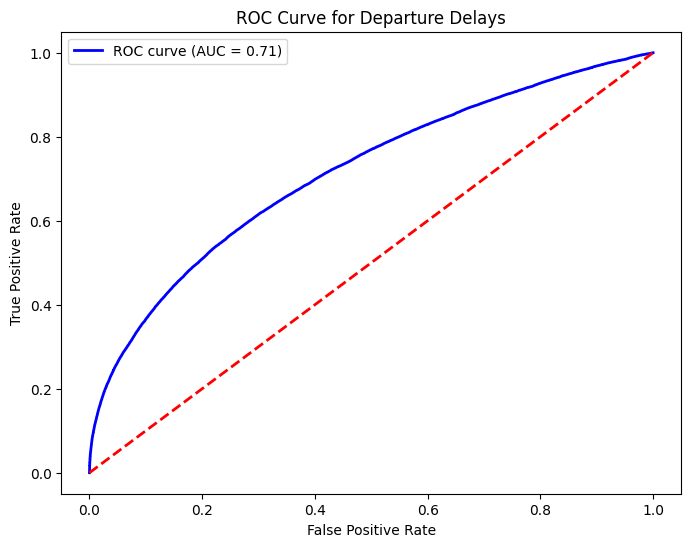

In [48]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(atl_deps_y_test, dep_delay_probabilities)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {dep_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Departure Delays')
plt.legend(loc="best")
plt.show()

In [49]:
atl_arrs_X_sample, _, atl_arrs_y_sample, _ = train_test_split(
    atl_arrs_X_train,
    atl_arrs_y_train,
    train_size=0.15,
    stratify=atl_arrs_y_train,   
    random_state=6242
)

print("Sample size:", atl_arrs_X_sample.shape[0])

Sample size: 117945


In [50]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Initialize the base models
rf_arr_base = Pipeline([
    ("smote", SMOTE(random_state=6242)),
    ("rf", RandomForestClassifier(class_weight="balanced_subsample", random_state=6242))
])

scoring = {
    "roc_auc":   "roc_auc",
    "precision": "precision",
    "recall":    "recall",
    "f1":        "f1"
}


# Setup randomized searches with 20 iterations and 3-fold cross-validation
random_search_arr = RandomizedSearchCV(
    estimator=rf_arr_base,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring=scoring,
    refit= 'f1',
    random_state=6242,
    n_jobs=-1,
    verbose = 4
)

# Fit on the training data
random_search_arr.fit(atl_arrs_X_sample, atl_arrs_y_sample)
print(random_search_arr.best_params_)

# Get the best estimator
rf_arr_model = random_search_arr.best_estimator_
print(rf_arr_model)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'rf__bootstrap': False, 'rf__criterion': 'entropy', 'rf__max_depth': 60, 'rf__max_features': 0.8, 'rf__min_samples_leaf': 9, 'rf__min_samples_split': 2, 'rf__n_estimators': 200, 'smote__k_neighbors': 7, 'smote__sampling_strategy': 0.5}
Pipeline(steps=[('smote',
                 SMOTE(k_neighbors=7, random_state=6242,
                       sampling_strategy=0.5)),
                ('rf',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=60,
                                        max_features=0.8, min_samples_leaf=9,
                                        n_estimators=200, random_state=6242))])


In [51]:
rf_arr_model.fit(atl_arrs_X_train,atl_arrs_y_train)

Pipeline(steps=[('smote',
                 SMOTE(k_neighbors=7, random_state=6242,
                       sampling_strategy=0.5)),
                ('rf',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=60,
                                        max_features=0.8, min_samples_leaf=9,
                                        n_estimators=200, random_state=6242))])

In [52]:
#load local model or one saved 
import joblib
from joblib import dump, load
joblib.dump(rf_arr_model,'rf_arr_model.joblib')

import os
path = "rf_arr_model.joblib"


try:
    rf_arr_model
    print('model exists')
except NameError:
    
    if os.path.exists(path):
        rf_arr_model = load(path)
        print(f"Loaded model from {path}")
    else:
        raise FileNotFoundError(f"No model file found at {path}")

model exists


 Arrivals Delay Prediction Metrics:
Accuracy: 0.8257
Precision: 0.4723
Recall: 0.3477
ROC AUC: 0.7352
PR AUC: 0.4287

Detailed Classification Report for Arrivals:
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90    163653
         1.0       0.47      0.35      0.40     32923

    accuracy                           0.83    196576
   macro avg       0.67      0.63      0.65    196576
weighted avg       0.81      0.83      0.81    196576

KS Score for Arrivals Delay Predictions: 0.3490


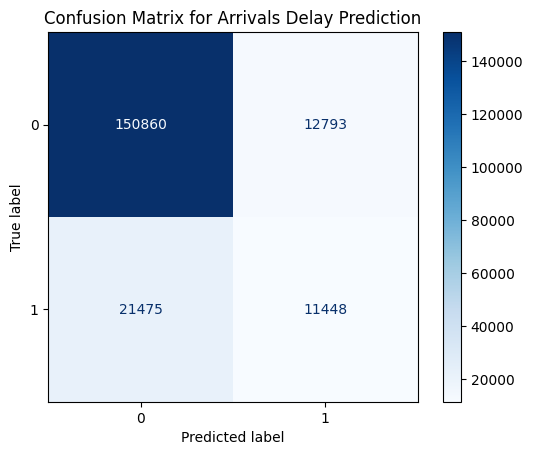

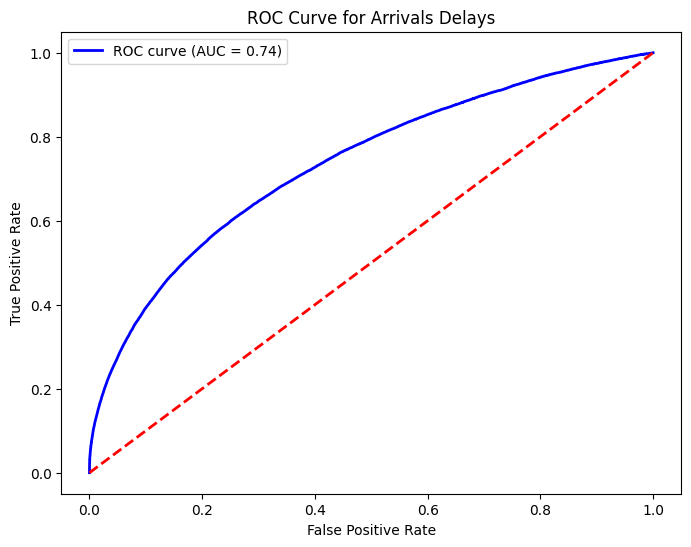

In [53]:
# Predict probabilities and classes on the test sets
arr_y_pred_proba = rf_arr_model.predict_proba(atl_arrs_X_test)
arr_delay_probabilities = arr_y_pred_proba[:, 1]
arr_y_pred = rf_arr_model.predict(atl_arrs_X_test)

# Evaluate the model
# Departures
arr_accuracy = accuracy_score(atl_arrs_y_test, arr_y_pred)
arr_precision = precision_score(atl_arrs_y_test, arr_y_pred)
arr_recall = recall_score(atl_arrs_y_test, arr_y_pred)
arr_roc_auc = roc_auc_score(atl_arrs_y_test, arr_delay_probabilities)
arr_pr_auc = average_precision_score(atl_arrs_y_test, arr_delay_probabilities)

# Create confusion matrix
arr_cm = confusion_matrix(atl_arrs_y_test, arr_y_pred)

# Print results
print(" Arrivals Delay Prediction Metrics:")
print(f"Accuracy: {arr_accuracy:.4f}")
print(f"Precision: {arr_precision:.4f}")
print(f"Recall: {arr_recall:.4f}")
print(f"ROC AUC: {arr_roc_auc:.4f}")
print(f"PR AUC: {arr_pr_auc:.4f}")
print("\nDetailed Classification Report for Arrivals:")
print(classification_report(atl_arrs_y_test, arr_y_pred))

# Calculate KS score for departure delay predictions
arr_ks_score = ks_score(atl_arrs_y_test, arr_delay_probabilities)

# Print the KS score
print(f"KS Score for Arrivals Delay Predictions: {arr_ks_score:.4f}")

from sklearn.metrics import ConfusionMatrixDisplay

# Visualize the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=arr_cm).plot(cmap='Blues')
plt.title("Confusion Matrix for Arrivals Delay Prediction")
plt.show()

# Plot the ROC curve
fpr, tpr, _ = roc_curve(atl_arrs_y_test, arr_delay_probabilities)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {arr_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Arrivals Delays')
plt.legend(loc="best")
plt.show()